<a href="https://colab.research.google.com/github/ADAMFUTUR/ADAMFUTUR/blob/main/Fake_News_Prediction_adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install -q kaggle

In [12]:
from google.colab import files

files.upload()

{}

In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [14]:
!kaggle datasets download adamimloul/news-articles-scv

Dataset URL: https://www.kaggle.com/datasets/adamimloul/news-articles-scv
License(s): unknown
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 896MB/s]


In [15]:
!ls /content

kaggle.json  news-articles-scv.zip  sample_data


In [16]:
!unzip /content/news-articles-scv.zip

Archive:  /content/news-articles-scv.zip
  inflating: news_articles.csv       


In [17]:
import pandas as pd

In [18]:
df = pd.read_csv('/content/news_articles.csv')


In [19]:
df.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement du texte
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Vectorisation et clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Pour le déploiement
from flask import Flask, request, render_template

# Charger le jeu de données
df = pd.read_csv("/content/news_articles.csv")


## 2. Prétraitement des données


##### Nettoyez et préparez les données textuelles pour le clustering.

In [21]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r"http\S+", "", text)  # Supprimer les URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Supprimer les caractères spéciaux
    text = text.lower()
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Appliquer le prétraitement
df['processed_text'] = df['text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 3. Vectorisation avec TF-IDF


In [22]:
vectorizer = TfidfVectorizer(max_df=0.7, min_df=5, max_features=1000)
X = vectorizer.fit_transform(df['processed_text'])


## 4. Clustering avec K-Means


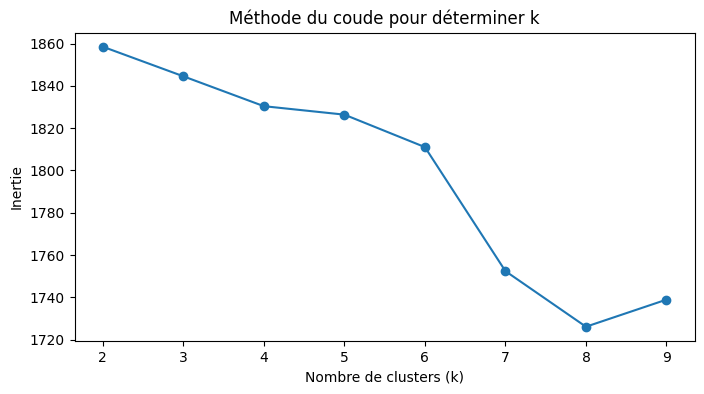

In [23]:
# Déterminer le nombre optimal de clusters (k) à l'aide de la méthode du coude
inertia = []
k_range = range(2, 10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

# Tracer la courbe du coude
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer k')
plt.show()

# Choisir le nombre optimal de clusters (par exemple, k=4)
k = 4
model = KMeans(n_clusters=k, random_state=42)
model.fit(X)
df['cluster'] = model.labels_


## 5. Visualisation des clusters


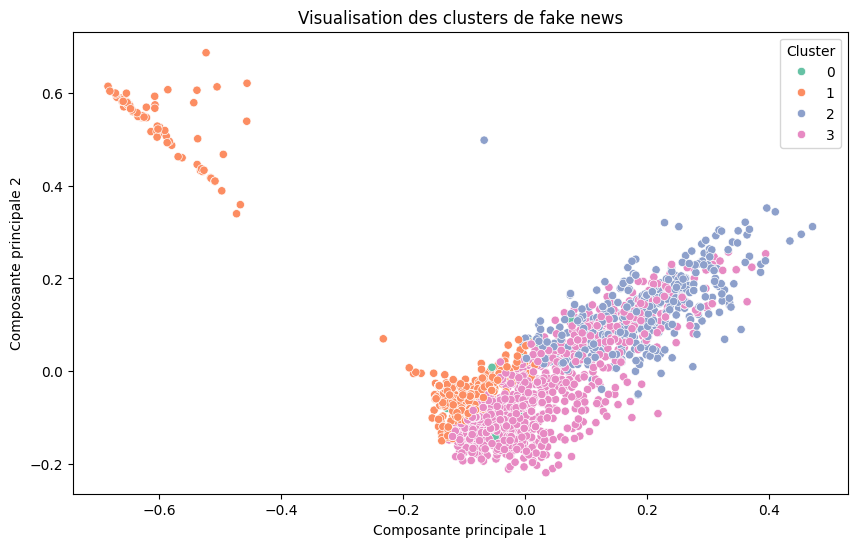

In [24]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='Set2')
plt.title('Visualisation des clusters de fake news')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend(title='Cluster')
plt.show()


In [25]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [26]:
import pickle

with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)


In [27]:
import pickle

# Charger le modèle K-Means
with open('/content/kmeans_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Charger le vectoriseur TF-IDF
with open('/content/tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)


##  Prétraiter le nouvel article


In [28]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Télécharger les stopwords si ce n'est pas déjà fait
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    if not text:
        return ""
    text = re.sub(r"http\S+", "", text)  # Supprimer les URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Supprimer les caractères spéciaux
    text = text.lower()
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Exemple d'article
new_article = """
In November 2016, a website called the Denver Guardian published a sensational story claiming that an FBI agent involved in the investigation of Hillary Clinton's email leaks was found dead in a murder-suicide. The article alleged that the agent had killed his wife before taking his own life.
"""

# Prétraitement
processed_article = preprocess_text(new_article)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Vectoriser le texte

In [29]:
X_new = vectorizer.transform([processed_article])


## Prédire le cluster

In [30]:
predicted_cluster = model.predict(X_new)[0]
print(f"L'article appartient au cluster : {predicted_cluster}")


L'article appartient au cluster : 3


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Encode labels: 'Fake' as 0, 'Real' as 1
df['label_encoded'] = df['label'].map({'Fake': 0, 'Real': 1})

# Vectorize the processed text column (assuming already preprocessed)
X = vectorizer.fit_transform(df['processed_text'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, df['label_encoded'], test_size=0.2, random_state=42
)

# Initialize and train the classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Evaluate on the test set
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.87      0.78       264
           1       0.62      0.37      0.47       155

    accuracy                           0.68       419
   macro avg       0.66      0.62      0.62       419
weighted avg       0.67      0.68      0.66       419



In [33]:
print(df['label'].isna().sum())


1


In [34]:
df = df.dropna(subset=['label'])


### logistic regression

In [36]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Make sure 'imblearn' is installed: !pip install imblearn

# Drop rows with missing labels
df = df.dropna(subset=['label'])

# Encode labels
df['label_encoded'] = df['label'].map({'Fake': 0, 'Real': 1})

# Vectorize the text
X = vectorizer.fit_transform(df['processed_text'])
y = df['label_encoded']

# Split the data first (important to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train classifier on resampled data
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate on the original test set
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.69      0.73       259
           1       0.58      0.68      0.63       160

    accuracy                           0.69       419
   macro avg       0.68      0.69      0.68       419
weighted avg       0.70      0.69      0.69       419



## Random forrest



In [37]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))


Random Forest:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78       259
           1       0.66      0.56      0.60       160

    accuracy                           0.72       419
   macro avg       0.70      0.69      0.69       419
weighted avg       0.72      0.72      0.72       419



## Naive Bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)

y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes:\n", classification_report(y_test, y_pred_nb))


Naive Bayes:
               precision    recall  f1-score   support

           0       0.79      0.58      0.67       259
           1       0.52      0.75      0.62       160

    accuracy                           0.64       419
   macro avg       0.66      0.66      0.64       419
weighted avg       0.69      0.64      0.65       419



## Support Vector Machine (SVM)

In [39]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_resampled, y_train_resampled)

y_pred_svm = svm_model.predict(X_test)
print("SVM:\n", classification_report(y_test, y_pred_svm))


SVM:
               precision    recall  f1-score   support

           0       0.80      0.71      0.75       259
           1       0.60      0.71      0.65       160

    accuracy                           0.71       419
   macro avg       0.70      0.71      0.70       419
weighted avg       0.72      0.71      0.71       419



## Gradient Boosting

In [40]:
%pip install xgboost


In [41]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
               precision    recall  f1-score   support

           0       0.76      0.76      0.76       259
           1       0.61      0.61      0.61       160

    accuracy                           0.70       419
   macro avg       0.68      0.68      0.68       419
weighted avg       0.70      0.70      0.70       419



## Hyperparameter Tuning with GridSearchCV

#### 1. Random Forest Tuning



In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                       cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)

grid_rf.fit(X_train_resampled, y_train_resampled)

print("Best RF Params:", grid_rf.best_params_)

# Evaluate best model
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Tuned Random Forest:\n", classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Tuned Random Forest:
               precision    recall  f1-score   support

           0       0.74      0.82      0.78       259
           1       0.65      0.53      0.58       160

    accuracy                           0.71       419
   macro avg       0.69      0.68      0.68       419
weighted avg       0.70      0.71      0.70       419



#### 2.  XGBoost Tuning

In [43]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb,
                        cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)

grid_xgb.fit(X_train_resampled, y_train_resampled)

print("Best XGB Params:", grid_xgb.best_params_)

# Evaluate best model
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("Tuned XGBoost:\n", classification_report(y_test, y_pred_xgb))


Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

param_dist_xgb = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3)
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,  # Try 20 random combinations
    cv=3,
    scoring='f1_weighted',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_xgb.fit(X_train_resampled, y_train_resampled)
print("Best XGB Params (Randomized Search):", random_search_xgb.best_params_)

best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("Random Search XGBoost:\n", classification_report(y_test, y_pred_xgb))


In [ ]:
import joblib

# Save the best model (e.g., XGBoost or RandomForest)
joblib.dump(best_xgb, 'xgb_model.pkl')
joblib.dump(best_rf, 'rf_model.pkl')

  # or 'rf_model.pkl' if using Random Forest

# Save the vectorizer (TF-IDF)
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


In [ ]:
# Load the model
loaded_model = joblib.load('xgb_model.pkl')

# Load the vectorizer
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Example prediction
sample_text = ["The government just announced something shocking!"]
sample_vectorized = loaded_vectorizer.transform(sample_text)
prediction = loaded_model.predict(sample_vectorized)

print("Prediction:", "Fake" if prediction[0] == 0 else "Real")
